# Unidad 4: Caso práctico

In [23]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Predicción de la miopía en una población

El archivo “myopia.csv” contiene los datos de un estudio realizado durante 5 años en los que se siguió la salud ocular de una población. Los registros se corresponde con los valores tomados inicialmente estudio y una variable "MYOPIC" en la que registra si al sujeto se le diagnostico miopía durante el estudio. Las variables son:

* ID: Identificador ID
* STUDYYEAR: Año en los que se inició el estudio
* MYOPIC: Desarrollo miopía dentro de los primeros cinco años
* AGE: Edad a primera visita
* GENDER: Genero
* SPHEQ: Refracción esférica equivalente
* AL: Longitud Axial
* ACD: Profundidad de cámara anterior
* LT: Grosor de la lente
* VCD: Profundidad de cámara vítrea
* SPORTHR: ¿Cuántas horas por semana fuera de la escuela el niño participó en deportes o actividades al aire libre?
* READHR: ¿Cuántas horas por semana fuera de la escuela el niño pasó leyendo por placer?
* COMPHR: ¿Cuántas horas por semana fuera de la escuela el niño pasó jugando a video juegos de ordenador o trabajando en el ordenador?
* STUDYHR: ¿Cuántas horas por semana fuera de escuela el niño pasa leyendo o estudiando para tareas escolares?
* TVHR: ¿Cuántas horas por semana fuera de la escuela el niño pasó mirando televisión?
* DIOPTERHR: Compendio de horas de actividades de trabajo cercano que se define como: DIOPTERHR = 3 * (READHR + STUDYHR) + 2 * COMPHR + TVHR
* MOMMY: ¿La madre del sujeto es miope?
* DADMY: ¿El padre del sujeto es miope?

Crear un modelo que pueda predecir la aparición de miopía en el conjunto de estudio.

### Importación de los datos
Inicialmente se importan los datos:

In [24]:
import pandas as pd

myopia = pd.read_csv('myopia.csv', sep = ';')

# Separación de la variable objetivo y las explicativas
target = 'MYOPIC'
features = list(myopia.columns)
features.remove('MYOPIC')

# Listado de variables disponibles para hacer un modelo.
for var in features:
    print(var , ':' , len(set(myopia[var])))

ID : 618
STUDYYEAR : 6
AGE : 5
GENDER : 2
SPHEQ : 511
AL : 254
ACD : 206
LT : 128
VCD : 226
SPORTHR : 40
READHR : 16
COMPHR : 18
STUDYHR : 14
TVHR : 28
DIOPTERHR : 75
MOMMY : 2
DADMY : 2


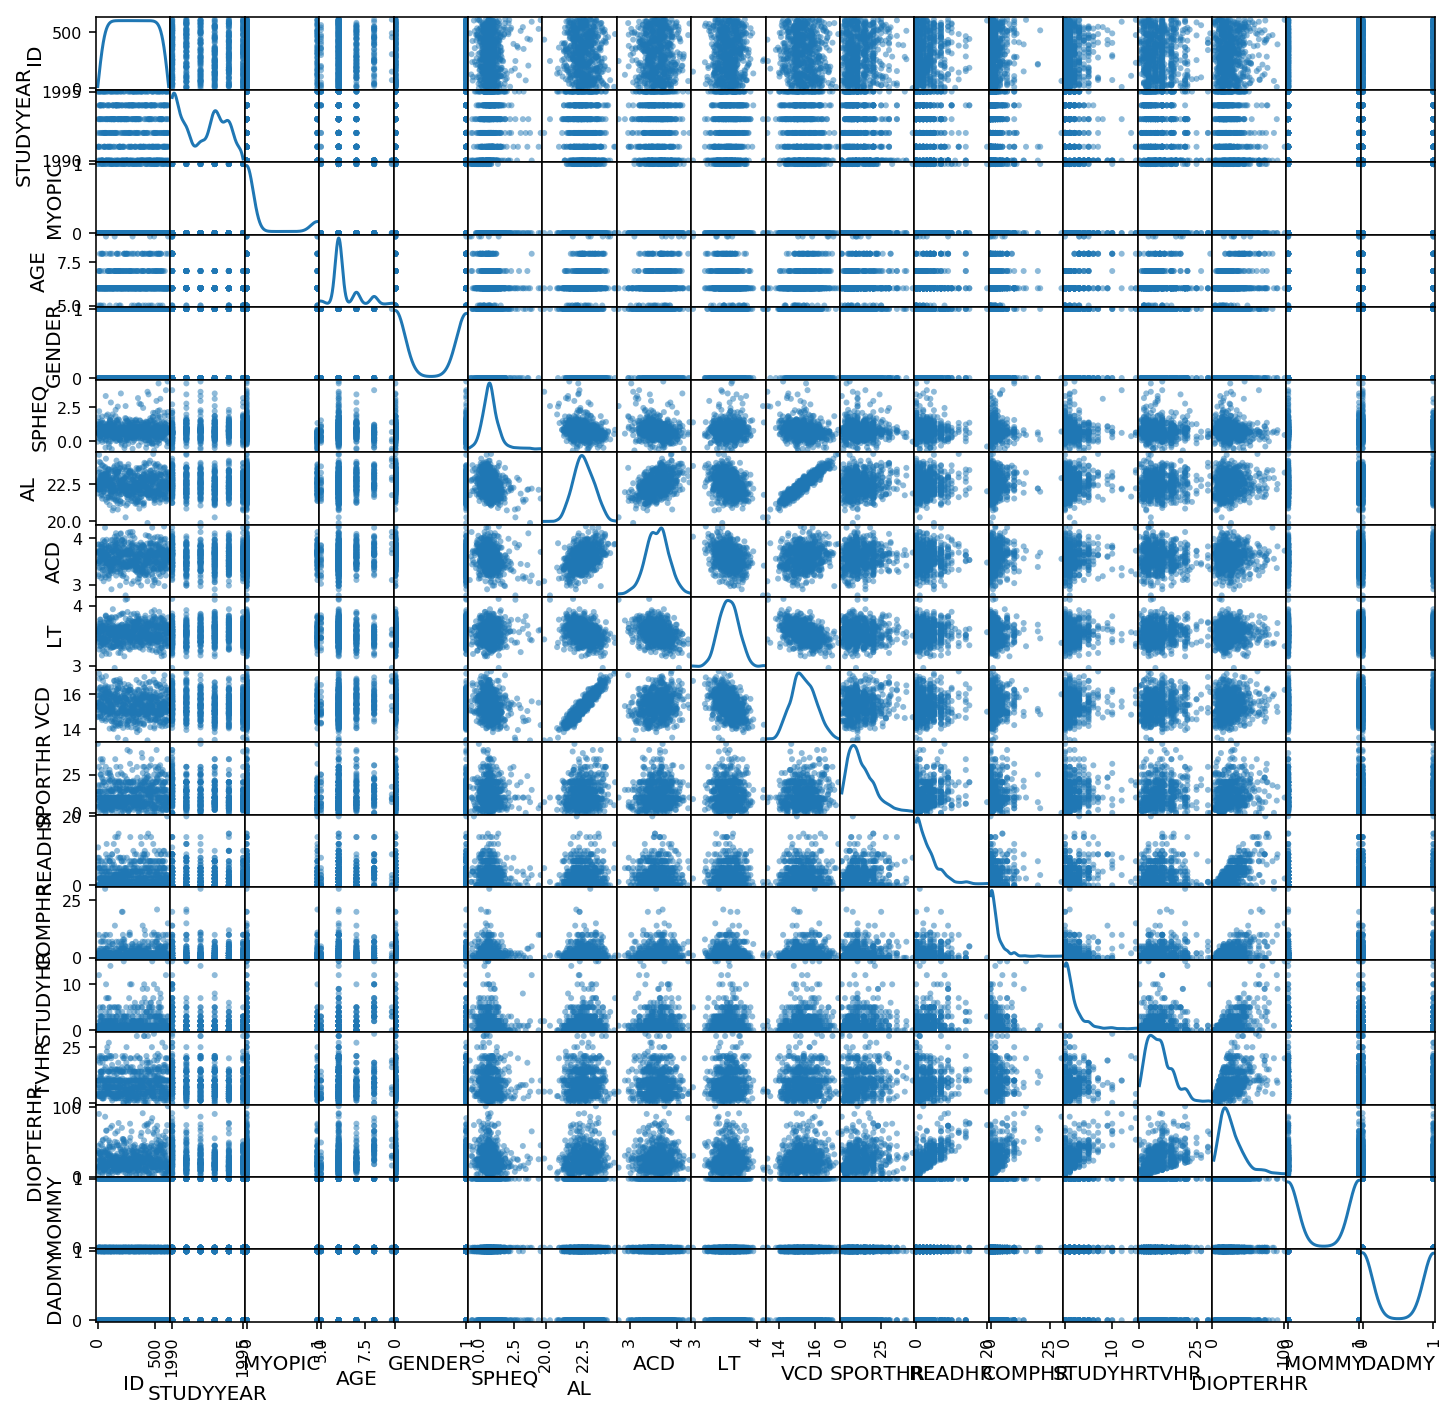

In [25]:
from pandas.plotting import scatter_matrix

scatter_matrix(myopia, figsize = (12, 12), diagonal = 'kde');

#### Eliminación de las variables que son identificadores
La variable `ID` es un identificadores de los pacientes, por lo que no se debe ser incluida en el modelo.

In [26]:
features.remove('ID')

Por otro lado la variable `STUDYYEAR` no se puede utilizar ya que en el caso de repetir el estudio no va a existir un nivel para realizr la predicción.

In [27]:
features.remove('STUDYYEAR')

#### Análisis de las variables discretas
En las variables discretas se ha de realizar un análisis para seleccionar las que tienen mayor capacidad predictiva.

In [28]:
myopia[features].head()

,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,6,1,-0.052,21.89,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,6,1,0.608,22.38,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,6,1,1.179,22.49,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,6,1,0.525,22.20,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,0,0.697,23.29,3.676,3.454,16.16,14,0,0,0,4,4,1,0


En la tabla se puede ver que las variables discretas que quedan son:
* AGE
* GENDER
* MOMMY
* DADMY

Para estas variables se puede obtener la tabla de frecuencias de cada una de ella para ver la posibilidad de que sean incluidas en el modelo y si pueden presentar problemas.

In [29]:
categorical = ['AGE', 'GENDER', 'MOMMY', 'DADMY']
continuous = ['SPHEQ', 'AL', 'ACD', 'LT', 'VCD', 'SPORTHR' ,'READHR', 'COMPHR', 'TVHR', 'DIOPTERHR']

for var in categorical:
    print("Tabla de frecuencias para:", var)
    print(pd.crosstab(myopia[target], myopia[var]))
    print

Tabla de frecuencias para: AGE
AGE      5    6   7   8  9
MYOPIC                    
0       17  398  73  45  4
1        4   58   9   8  2
Tabla de frecuencias para: GENDER
GENDER    0    1
MYOPIC          
0       281  256
1        35   46
Tabla de frecuencias para: MOMMY
MOMMY     0    1
MYOPIC          
0       279  258
1        26   55
Tabla de frecuencias para: DADMY
DADMY     0    1
MYOPIC          
0       285  252
1        25   56


Solamente es necesario analizar la variable `AGE` ya que el resto solamente tienen dos niveles.
##### Variable: `AGE`

In [30]:
def get_WoE(data, var, target):
    crosstab = pd.crosstab(data[target], data[var])
    
    print("Obteniendo el Woe para la variable", var, ":")
    
    for col in crosstab.columns:
        if crosstab[col][1] == 0:
            print("  El WoE para", col, "[", sum(crosstab[col]), "] es infinito")
        else:
            print("  El WoE para", col, "[", sum(crosstab[col]), "] es", np.log(float(crosstab[col][0]) / float(crosstab[col][1])))

In [31]:
get_WoE(myopia, 'AGE', target)

Obteniendo el Woe para la variable AGE :
  El WoE para 5 [ 21 ] es 1.4469189829363254
  El WoE para 6 [ 456 ] es 1.9260089947380183
  El WoE para 7 [ 82 ] es 2.093234863812172
  El WoE para 8 [ 53 ] es 1.7272209480904839
  El WoE para 9 [ 6 ] es 0.6931471805599453


In [32]:
myopia.loc[:, 'AGE_grp'] = None

for row in myopia.index:
    if myopia.loc[row, 'AGE'] <= 7:
        myopia.loc[row, 'AGE_grp'] = True
    else:
        myopia.loc[row, 'AGE_grp'] = False

get_WoE(myopia, 'AGE_grp', target)

Obteniendo el Woe para la variable AGE_grp :
  El WoE para False [ 59 ] es 1.589235205116581
  El WoE para True [ 559 ] es 1.9276355288118316


In [33]:
features.remove('AGE')
features.append('AGE_grp')

categorical.remove('AGE')
categorical.append('AGE_grp')

##### Evaluación del IV
Al ser todas las variables binarias se puede analizar con en IV la capacidad predictiva de las mismas.

In [34]:
from sklearn.linear_model.logistic import LogisticRegression

def calculateIV(data, features, target):
    result = pd.DataFrame(index = ['IV'], columns = features)
    result = result.fillna(0)
    var_target = array(data[target])
    
    for cat in features:
        var_values = array(data[cat])
        var_levels = unique(var_values)

        mat_values = numpy.zeros(shape=(len(var_levels),2))
        
        for i in range(len(var_target)):
            for j in range(len(var_levels)):
                if var_levels[j] == var_values[i]:
                    pos = j
                    break

            # Estimación del número valores en cada nivel
            if var_target[i]:
                mat_values[pos][0] += 1
            else:
                mat_values[pos][1] += 1

            # Obtención del IV
            IV = 0
            for j in range(len(var_levels)):
                if mat_values[j][0] > 0 and mat_values[j][1] > 0:
                    rt = mat_values[j][0] / (mat_values[j][0] + mat_values[j][1])
                    rf = mat_values[j][1] / (mat_values[j][0] + mat_values[j][1])
                    IV += (rt - rf) * np.log(rt / rf)
                    
        # Se agrega el IV al listado
        result[cat] = IV
        
    return result

calculateIV(myopia, categorical, target)

,GENDER,MOMMY,DADMY,AGE_grp
IV,2.815199,2.970954,2.998235,2.488479


En este caso todas las variables muestran una relación fuerte con la variable objetivo (IV > 0.5). Ya que son binarias no es necesario crear variables dummies.

#### Análisis de las variables continuas
El resto de las variables que quedan son numéricas. Se pueden analizar para ver cómo se relacionan con la variable objetivo.

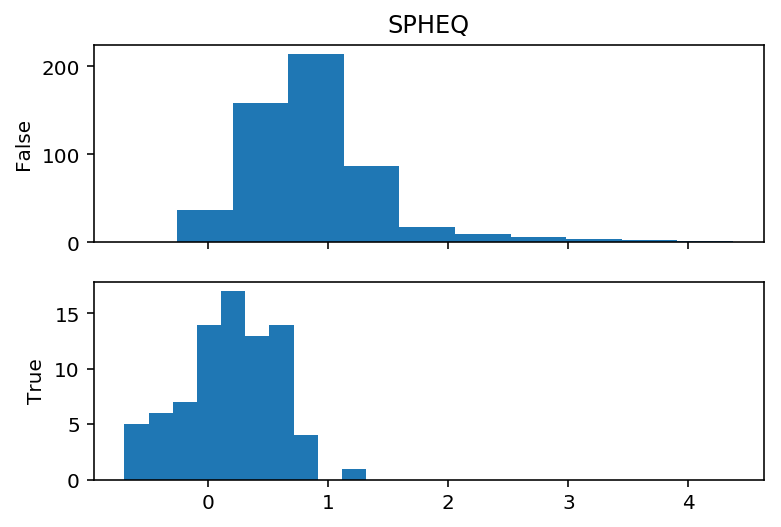

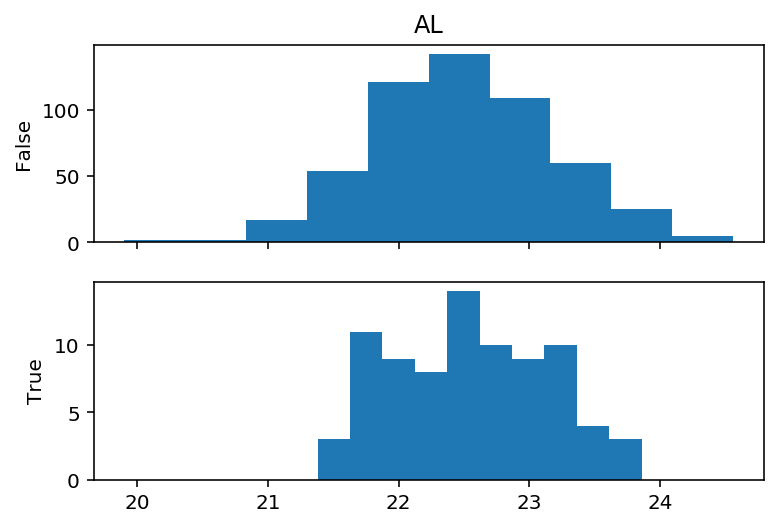

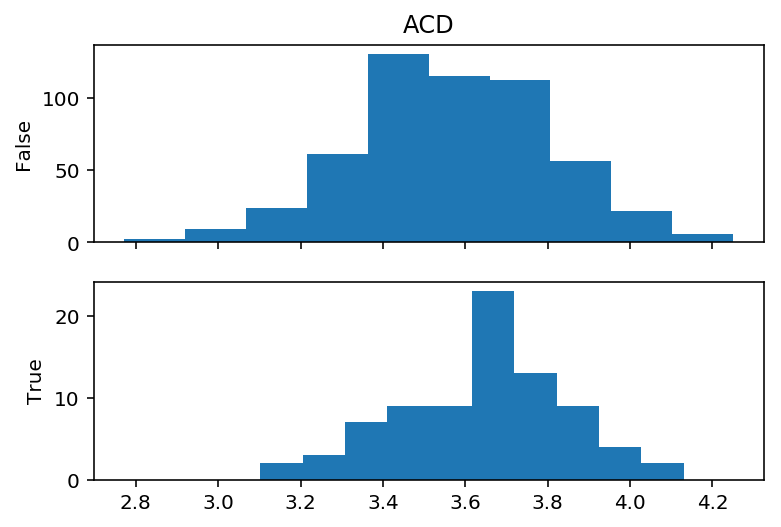

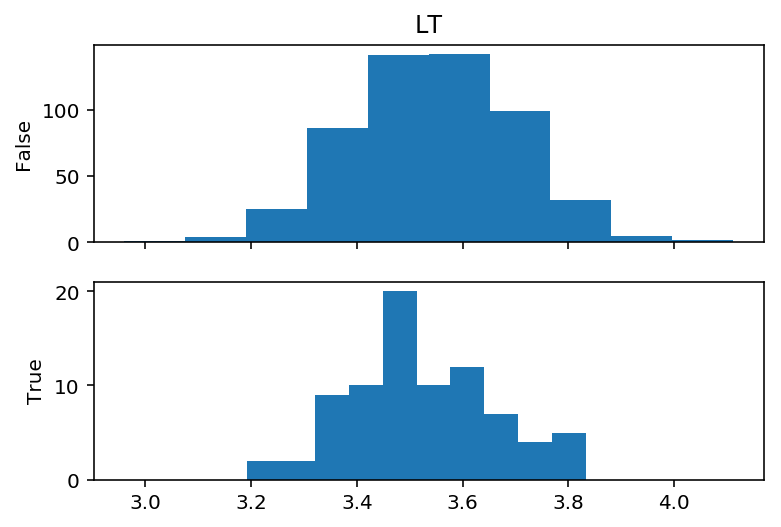

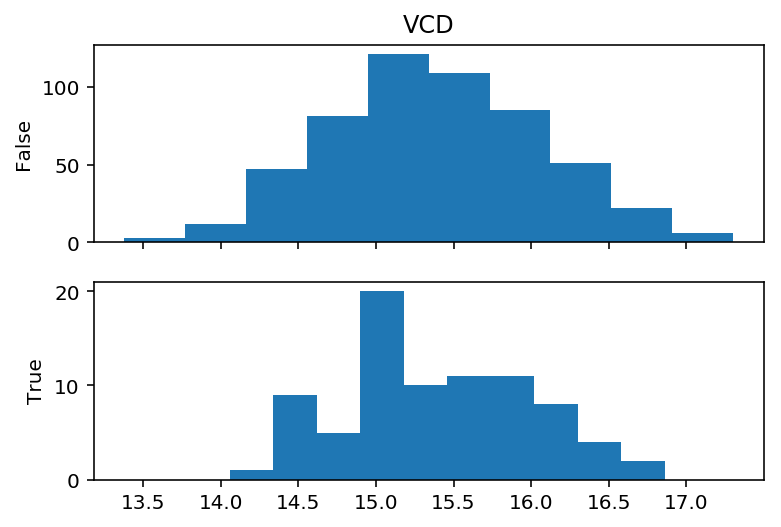

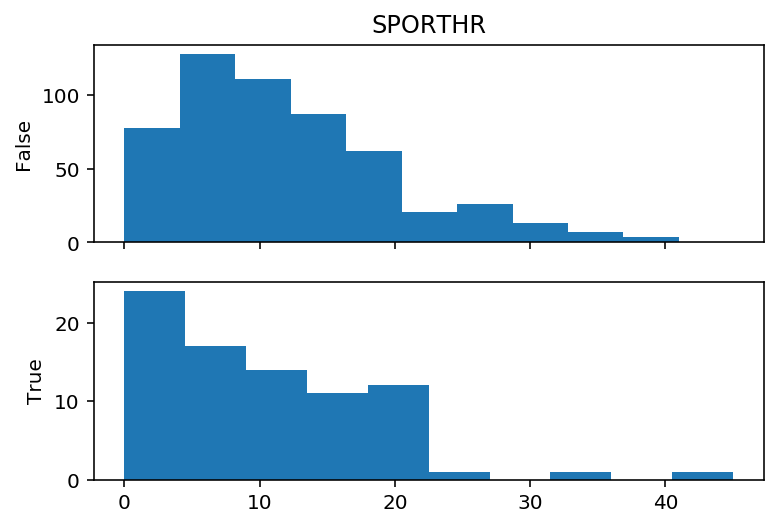

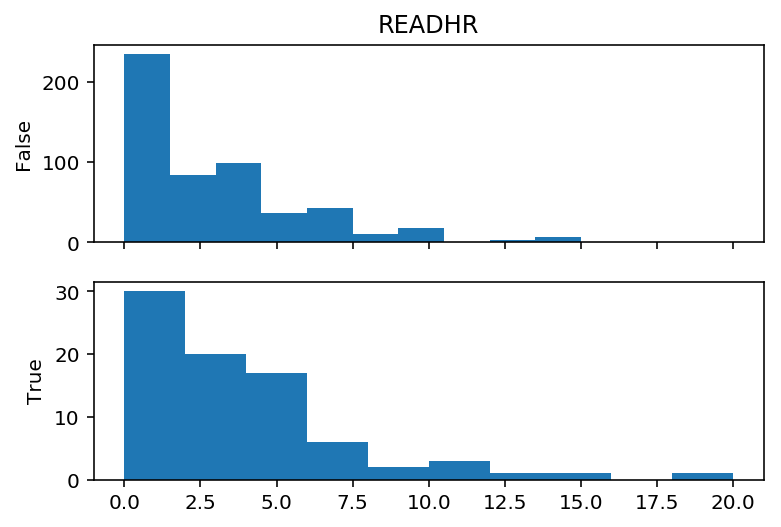

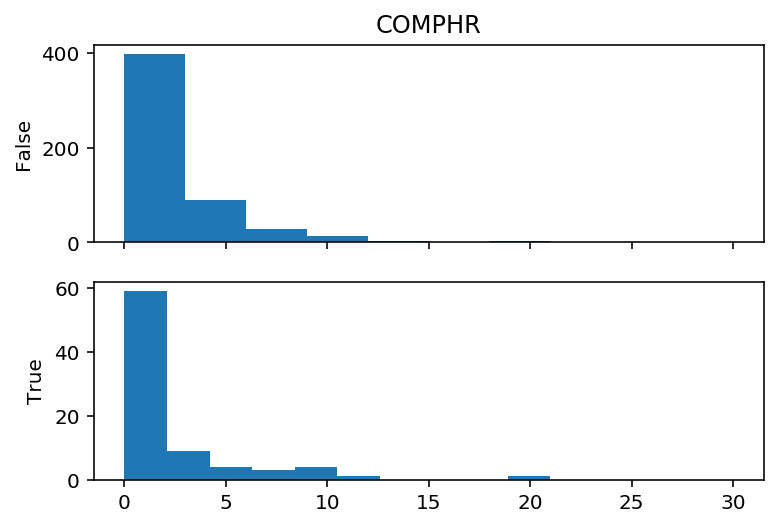

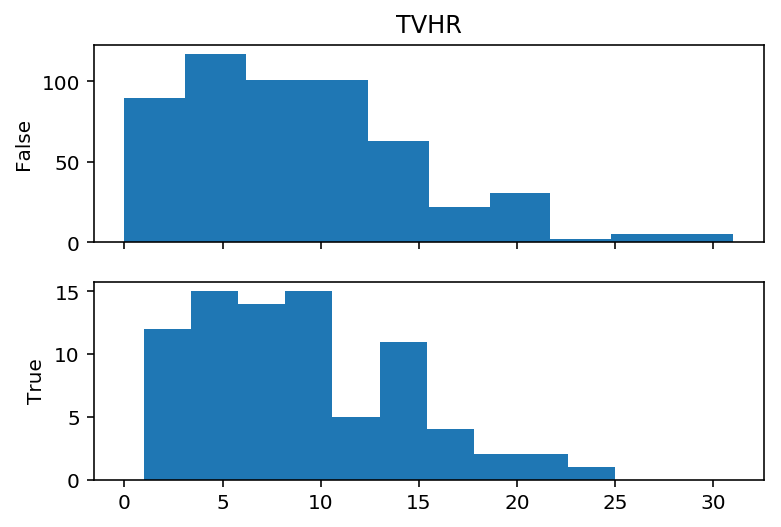

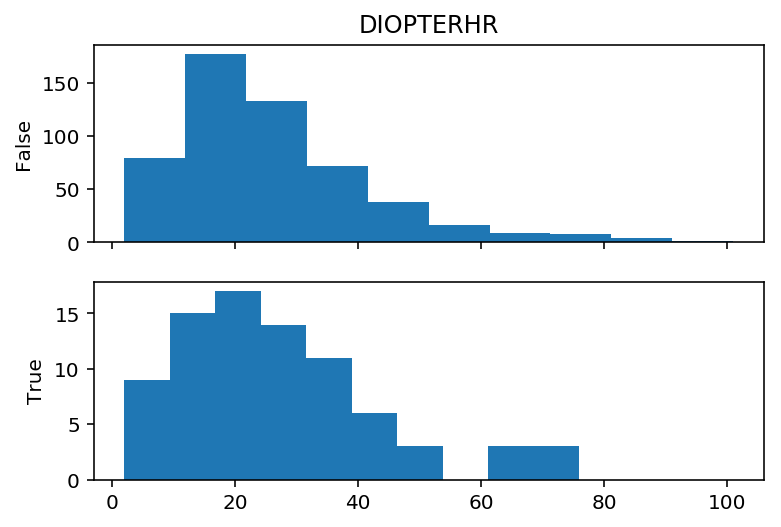

In [35]:
for var in continuous:
    f, axarr = plt.subplots(2, sharex = True)
    
    axarr[0].hist(myopia[var][myopia[target]==0])
    axarr[1].hist(myopia[var][myopia[target]==1])
    
    axarr[0].set_ylabel('False')
    axarr[1].set_ylabel('True')
    axarr[0].set_title(var)

Se puede observar que puede ser interesante realizar una categorización de las variables:

* `SPHEQ`

#### Variable: `SPHEQ`

In [36]:
myopia.loc[:, 'SPHEQ_grp'] = myopia['SPHEQ'].map(lambda x: 'n0' if x < 0.05 else 'n1' if x < 0.6 else 'n2')
get_WoE(myopia, 'SPHEQ_grp', target)
calculateIV(myopia, ['SPHEQ_grp'], target)

Obteniendo el Woe para la variable SPHEQ_grp :
  El WoE para n0 [ 43 ] es -0.7282385003712154
  El WoE para n1 [ 184 ] es 1.3460204619819507
  El WoE para n2 [ 391 ] es 3.293187857832752


,SPHEQ_grp
IV,4.101451


Eliminación de las variables modificadas

In [37]:
features.remove('SPHEQ')
features.append('SPHEQ_grp')

continuous.remove('SPHEQ')
categorical.append('SPHEQ_grp')

### Creación de un modelo
Una vez transformadas las variables se puede proceder a la creación de un modelo.

In [38]:
use_features = features[:]
use_features.remove('SPHEQ_grp')

data_model = pd.concat([myopia[use_features], pd.get_dummies(myopia['SPHEQ_grp'], prefix = 'pclass')], axis = 1)

#### Eliminación de variables colineales

In [39]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

In [40]:
calculateVIF(data_model)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


,GENDER,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,AGE_grp,pclass_n0,pclass_n1,pclass_n2
VIF,1.263202,30817.479668,3532.419376,1592.293953,29423.355139,1.08938,inf,inf,inf,inf,inf,1.046047,1.025207,1.43606,inf,inf,inf


In [41]:
model_vars = selectDataUsingVIF(data_model)
calculateVIF(model_vars)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


,GENDER,ACD,LT,VCD,SPORTHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,AGE_grp,pclass_n1,pclass_n2
VIF,1.259612,1.267044,1.414834,1.422173,1.088936,1.655021,2.336791,1.452902,3.360719,1.039444,1.024922,1.430885,3.839615,3.984859


In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(model_vars, myopia[target])

### Creación de un modelo y validación de un modelo

In [43]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print("La matriz de confusión es ")
    print(confusion_matrix)

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', auc(false_positive_rate, recall))

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

La matriz de confusión es 
[[404   5]
 [ 44  10]]
Precisión: 0.8941684665226782
Exactitud: 0.6666666666666666
Exhaustividad: 0.18518518518518517
F1: 0.28985507246376807
AUC: 0.5864801231549397


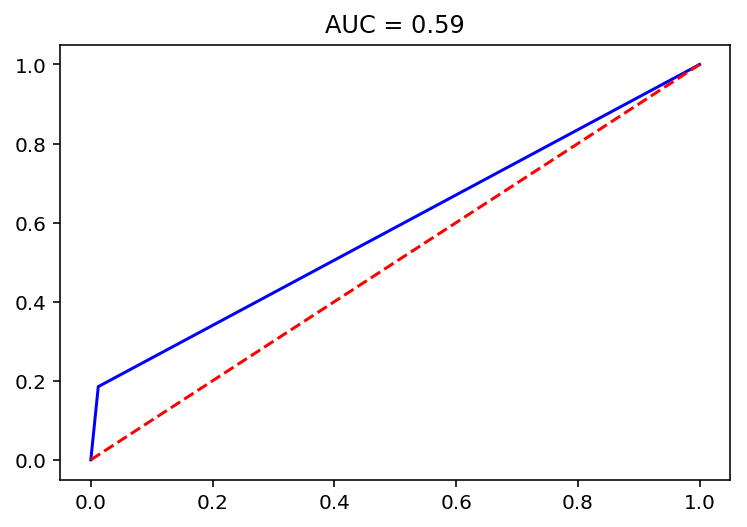

In [44]:
from sklearn.linear_model.logistic import LogisticRegression

model = LogisticRegression().fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

metricas_modelos(y_train, y_pred_train)

La matriz de confusión es 
[[127   1]
 [ 21   6]]
Precisión: 0.8580645161290322
Exactitud: 0.8571428571428571
Exhaustividad: 0.2222222222222222
F1: 0.35294117647058826
AUC: 0.6072048611111112


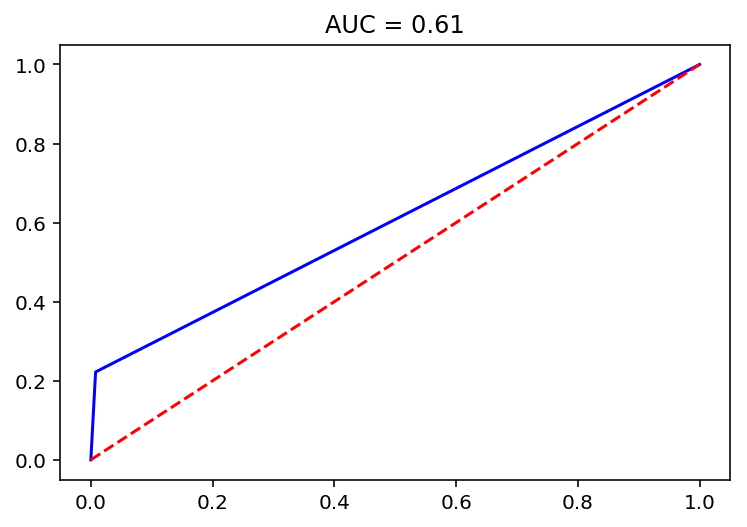

In [45]:
metricas_modelos(y_test, y_pred_test)

Se puede observar que en los dos conjuntos de datos la capacidad predictiva del modelo es muy parecida. Esto hace innecesario eliminar más variables con técnicas como Stepwise.